# Assignment 3
The objective of this assignment is to get you familiarize with `AutoEncoders`.

## Instructions
- Run this notebook on ```Google Colab(preferable)```
- Write your code and analysis in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of other cells. 

## Note
- Code snippets are in ``Pytorch``. If you are comfortable with ``Keras`` feel free to use it. No restrictions on the frameworks

## Datasets 
- CIFAR10

## Packages Used
- Pytorch 
- Refer this link to get familiarity with pytorch and CIFAR10 dataset[link](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>_Assignment3_Q2.ipynb`.

## Question 2 : Autoencoders


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

### Load CIFAR 10 Dataset

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("Train Data shape:", trainset.data.shape)
print("Test Data shape:", testset.data.shape)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train Data shape: (50000, 32, 32, 3)
Test Data shape: (10000, 32, 32, 3)


### Visualize the Data

torch.Size([16, 3, 32, 32])
torch.Size([16])


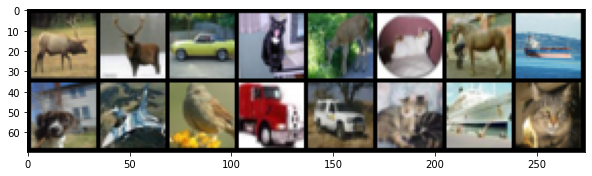

In [3]:
def imshow(img):
    img = img #/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# show images
imshow(torchvision.utils.make_grid(images))

### Define Model
Refer ``` torch.nn ``` [link](https://pytorch.org/docs/stable/nn.html) 

Experiment with different architectures of encoder and decoder i.e
- encoder and decoder is fully connected layers
- encoder and decoder is combination of convolution layers + fully connected layers
- encoder and decoder is fully convolutional layers.

In [4]:
class Autoencoder_MLP(nn.Module):
    def __init__(self):
        super(Autoencoder_MLP, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*32*32,1024),
            nn.ReLU(),
            nn.Linear(1024,256),
            nn.ReLU(),
            nn.Linear(256,64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64,256),
            
            nn.ReLU(),
            # nn.Dropout(0.25),
            nn.Linear(256, 1024),
            
            nn.ReLU(),
            nn.Linear(1024, 3*32*32),
            
            nn.Sigmoid(),
            nn.Unflatten(1,(3,32,32))
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded



class Autoencoder_Conv(nn.Module):
    def __init__(self):
        super(Autoencoder_Conv, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
            
            # Write your code here
            #nn.Conv2d(3, 12, 4, stride=2, padding=1),
            #nn.ReLU(),
        )
        self.decoder = nn.Sequential(            
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Sigmoid(),

            # Write your code here
            #nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            #nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded



class Autoencoder3(nn.Module):
    def __init__(self):
        super(Autoencoder3, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4*4*48,128),
          
        )
        self.decoder = nn.Sequential(
            nn.Linear(128,4*4*48),
            nn.ReLU(),
            nn.Unflatten(1,(48,4,4)),
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Sigmoid(),
            
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


In [9]:
def print_model(encoder, decoder):
    print("############## Encoder ##############")
    print(encoder)
    print("############## Decoder ##############")
    print(decoder)
    print("")

def create_model():
  autoencoder1 = Autoencoder_MLP().cuda()
  print_model(autoencoder1.encoder, autoencoder1.decoder)
  autoencoder2 = Autoencoder_Conv().cuda()
  print_model(autoencoder2.encoder, autoencoder2.decoder)
  autoencoder3 = Autoencoder3().cuda()
  print_model(autoencoder3.encoder, autoencoder3.decoder)
  return autoencoder1,autoencoder2,autoencoder3

### Loss and Optimizer

In [10]:
autoencoder1,autoencoder2,autoencoder3 = create_model()
criterion = nn.MSELoss()
optimizer1 = optim.Adam(autoencoder1.parameters())
optimizer2 = optim.Adam(autoencoder2.parameters())
optimizer3 = optim.Adam(autoencoder3.parameters())

############## Encoder ##############
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=1024, bias=True)
  (2): ReLU()
  (3): Linear(in_features=1024, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=64, bias=True)
  (6): ReLU()
)
############## Decoder ##############
Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=1024, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1024, out_features=3072, bias=True)
  (5): Sigmoid()
  (6): Unflatten(dim=1, unflattened_size=(3, 32, 32))
)

############## Encoder ##############
Sequential(
  (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
)
############## Decoder ##############


### Training

In [11]:
for epoch in range(10):
	running_loss = 0.0
	for i, (inputs, _) in enumerate(trainloader, 0):
			inputs = Variable(inputs).cuda()
	
			# ============ Forward ============
			encoded, outputs = autoencoder1(inputs)
			loss = criterion(outputs, inputs)
			# ============ Backward ============
			optimizer1.zero_grad()
			loss.backward()
			optimizer1.step()
	
			# ============ Logging ============
			running_loss += loss.data
			if i % 2000 == 1999:
				print('[%d, %5d] loss: %.3f' %
					(epoch + 1, i + 1, running_loss / 2000))
				running_loss = 0.0
	
print('Finished Training')
print('Saving Model...')
torch.save(autoencoder1.state_dict(), "autoencoder_mlp.pt")

[1,  2000] loss: 0.029
[2,  2000] loss: 0.021
[3,  2000] loss: 0.019
[4,  2000] loss: 0.018
[5,  2000] loss: 0.017
[6,  2000] loss: 0.017
[7,  2000] loss: 0.017
[8,  2000] loss: 0.017
[9,  2000] loss: 0.017
[10,  2000] loss: 0.017
Finished Training
Saving Model...


In [12]:
for epoch in range(10):
	running_loss = 0.0
	for i, (inputs, _) in enumerate(trainloader, 0):
			inputs = Variable(inputs).cuda()
	
			# ============ Forward ============
			encoded, outputs = autoencoder2(inputs)
			loss = criterion(outputs, inputs)
			# ============ Backward ============
			optimizer2.zero_grad()
			loss.backward()
			optimizer2.step()
	
			# ============ Logging ============
			running_loss += loss.data
			if i % 2000 == 1999:
				print('[%d, %5d] loss: %.3f' %
					(epoch + 1, i + 1, running_loss / 2000))
				running_loss = 0.0
	
print('Finished Training')
print('Saving Model...')
torch.save(autoencoder2.state_dict(), "autoencoder_conv.pt")

[1,  2000] loss: 0.012
[2,  2000] loss: 0.005
[3,  2000] loss: 0.003
[4,  2000] loss: 0.003
[5,  2000] loss: 0.003
[6,  2000] loss: 0.002
[7,  2000] loss: 0.002
[8,  2000] loss: 0.002
[9,  2000] loss: 0.002
[10,  2000] loss: 0.002
Finished Training
Saving Model...


In [13]:
for epoch in range(10):
	running_loss = 0.0
	for i, (inputs, _) in enumerate(trainloader, 0):
			inputs = Variable(inputs).cuda()
	
			# ============ Forward ============
			encoded, outputs = autoencoder3(inputs)
			loss = criterion(outputs, inputs)
			# ============ Backward ============
			optimizer3.zero_grad()
			loss.backward()
			optimizer3.step()
	
			# ============ Logging ============
			running_loss += loss.data
			if i % 2000 == 1999:
				print('[%d, %5d] loss: %.3f' %
					(epoch + 1, i + 1, running_loss / 2000))
				running_loss = 0.0
	
print('Finished Training')
print('Saving Model...')
torch.save(autoencoder3.state_dict(), "autoencoder3.pt")

[1,  2000] loss: 0.019
[2,  2000] loss: 0.009
[3,  2000] loss: 0.007
[4,  2000] loss: 0.006
[5,  2000] loss: 0.006
[6,  2000] loss: 0.005
[7,  2000] loss: 0.005
[8,  2000] loss: 0.005
[9,  2000] loss: 0.005
[10,  2000] loss: 0.005
Finished Training
Saving Model...


### Load the saved model and Reconstruct the image

In [14]:
autoencoder1.load_state_dict(torch.load("/content/autoencoder_mlp.pt"))
autoencoder2.load_state_dict(torch.load("/content/autoencoder_conv.pt"))
autoencoder3.load_state_dict(torch.load("/content/autoencoder3.pt"))

<All keys matched successfully>

#### Provide Qualitative Results and Aanlysis with different encoder and decoder architectures as mentioned above.

GroundTruth:    cat  ship  ship plane  frog


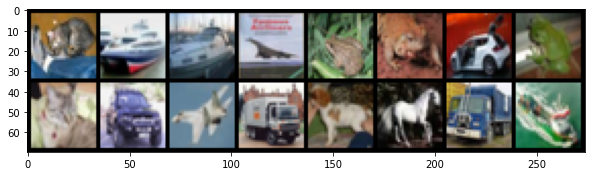

Reconstructed image for Fully Connected layers


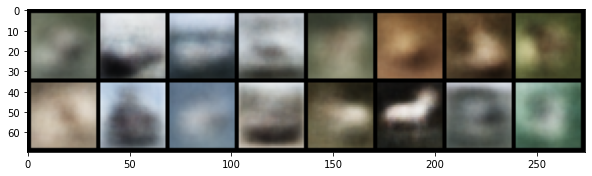

Reconstructed image for Fully Convolution Layers


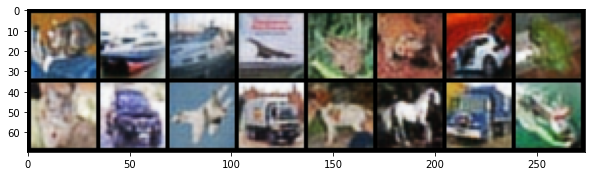

Reconstructed image for combination of convolution and connected layers


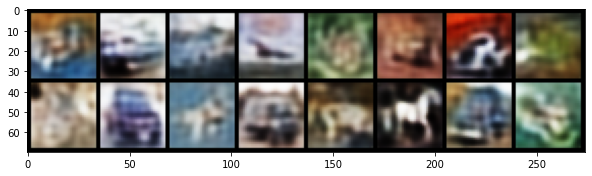

In [15]:
dataiter = iter(testloader)
images, labels = dataiter.next()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images))
images = Variable(images).cuda()

print("Reconstructed image for Fully Connected layers")
decoded_imgs = autoencoder1(images)[1]
decoded_imgs = decoded_imgs.cpu()
imshow(torchvision.utils.make_grid(decoded_imgs.data))

print("Reconstructed image for Fully Convolution Layers")
decoded_imgs = autoencoder2(images)[1]
decoded_imgs = decoded_imgs.cpu()
imshow(torchvision.utils.make_grid(decoded_imgs.data))

print("Reconstructed image for combination of convolution and connected layers")
decoded_imgs = autoencoder3(images)[1]
decoded_imgs = decoded_imgs.cpu()
imshow(torchvision.utils.make_grid(decoded_imgs.data))


#### 2.1 What are the Applications of Autoencoders and different types of Autoencoders

Some applications of autoencoders are:


*   Dimensionality Reduction
*   Image Compression
*   Image Denoising
*   Feature Extraction
*   Image generation
*   Sequence to sequence prediction
*   Recommendation system

Different types of autoencoders are:


*   Sparse Autoencoders
*   Denoising Autoencoders
*   Contractive Autoencoders
*   Deep Autoencoders





####2.2 PCA versus Autoencoders. Give detailed differences between them. (can use equations in latex and figures for the justification).


The major differences amongst PCA and Autoencoders are:

*   PCA is quicker and less expensive to compute than autoencoders.
*   PCA is quite similar to a single layered autoencoder with a linear activation function.
*   PCA is fundamentally a linear transformation, auto-encoders may describe complicated non-linear processes.
*   Because of the large number of parameters, the autoencoder is prone to overfitting.




